## Motivation  
Quite often, ensemble models work considerably better than linear/logistic regession models.

However, while linear models provide a coefficient for each variable ,that can be easily translated to it's effect on the explained variable direction (i.e. - negative/positive coefficient suggests negative/positive correlation with the explained variable,respectively), ensemble models doesn't provide this type of information.

That's because trees can result different splits for the same variable - some can have positive (value larger than split point leads to higher outcome value) and others negative effect in different estimators (trees).

Thus, proposed here a new method. The method is applied on Random Forest model and provides the average effect on the outcome - the more negative/positive the resulted value, the more the negative/positive effect on the explained variable (the Outcome).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Directions function

In [2]:
def get_directions(orig_table_,outcome,model,n_sample):
    from collections import defaultdict
    
    X_test = orig_table_.drop(outcome,1).sample(n_sample) # Select N samples from the data
    orig_table = orig_table_.copy()  # Define the original Data frame:          

    # Get features names , as in the original Data Frame:
    feature_names = pd.Series(orig_table_.drop(outcome,1).columns)
    feature_names[-2] = None

    # Initialize dictionary, for each possible direction
    dict_signs = defaultdict(dict)
    for col in X_test.columns: 
        dict_signs[col]["<="] = []
        dict_signs[col][">"] = []
        
    for i,estimator in enumerate(model.estimators_): # For each tree in Forest
        leave_id = estimator.apply(X_test)
        # Take only one sample from each leaf. After calculating the delta contribution, multiply it by total samples number 
        mm = pd.Series(estimator.apply(X_test)).reset_index(name='leaf').groupby('leaf')['index'].agg({'f' : 'first','s':'size'})
        for ind, sample_id in enumerate(mm['f']):  # For each of the selected samples
            xt = orig_table.drop(outcome,1) 
            
            feature = estimator.tree_.feature
            threshold = estimator.tree_.threshold
            node_indicator = estimator.decision_path(X_test)
            

            # Get the nodes list of the given sample's path:
            node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                                node_indicator.indptr[sample_id + 1]]

            for node_id in node_index:
                if leave_id[sample_id] == node_id:
                    continue
                # For each split, calculates mean of outcome at left ("<=") and right (">") children.
                # Then , calculate: LEFT child's outcome mean outcome - previous mean & RIGHT child's outcome mean outcome - previous mean
                prev_mean = orig_table.loc[xt.index,outcome].mean()
        
                if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
                    threshold_sign = "<="
                    xt = xt[xt[feature_names[feature[node_id]]]<=threshold[node_id]]
                else:
                    threshold_sign = ">"
                    xt = xt[xt[feature_names[feature[node_id]]]>threshold[node_id]]
                
                new_mean = orig_table.loc[xt.index,outcome].mean()
                
                dict_signs[feature_names[feature[node_id]]][threshold_sign] += [new_mean - prev_mean]*mm.iloc[ind]['s']

    directions = pd.DataFrame(dict_signs).T.apply(lambda x: x.apply(lambda y: np.mean(y))).dropna()
    return  directions

In [3]:
f = pd.read_csv("diabetes.csv")

### Impute Zero values here: 

In [4]:
f_impute_zeros = f.copy()

In [5]:
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_impute_zeros.loc[f_impute_zeros[col]==0,col] = f_impute_zeros.loc[f[col]>0,col].mean()
    #f = f[f[col]>0]

In [6]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

### Run "Rough" RandomForest model:

In [7]:
model=ensemble.RandomForestClassifier(min_samples_leaf=15,max_depth = 5,n_estimators=25)
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.8125
0.8970671641791045


### Directions

In [8]:
%%capture
directions = get_directions(orig_table_=f_impute_zeros.copy(),n_sample=150,outcome='Outcome',model=model)

In [9]:
directions.style.applymap(lambda x: 'color: red' if x<0 else  'color: green' )

,<=,>
Pregnancies,-0.0440505,0.0754404
Glucose,-0.118458,0.215452
BloodPressure,-0.0163286,0.0183101
SkinThickness,-0.0681764,0.0481699
Insulin,-0.030335,0.0636793
BMI,-0.142847,0.0838707
DiabetesPedigreeFunction,-0.0557683,0.0812604
Age,-0.0940081,0.10286


Finally, substract the '<=' direction  from '>' direction. For example, Glucose variable has strong positive/negative effect on the outcome when following a path towards higher/lower Glucose values. Hence, **Their subtraction will provide stronger estimate for the effect of each variable on the outcome's direction**

In [10]:
directions.T.diff().iloc[1]

Pregnancies                 0.119491
Glucose                     0.333910
BloodPressure               0.034639
SkinThickness               0.116346
Insulin                     0.094014
BMI                         0.226718
DiabetesPedigreeFunction    0.137029
Age                         0.196868
Name: >, dtype: float64

#### Compare directions with simple-splits (how much >/<= values correlated with 0/1)

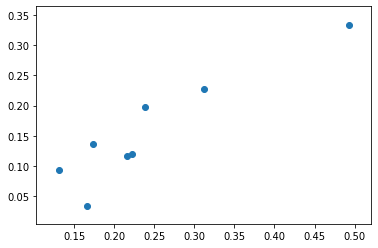

,l1,l2
l1,1.00000,0.92364
l2,0.92364,1.00000


In [11]:
l1= f_impute_zeros.corr()[outcome] 
l2= directions.T.diff().iloc[1]
ll = l1.reset_index(name='l1').set_index('index')
ll['l2'] = l2
plt.scatter(ll['l1'],ll['l2'])
plt.show()
ll.corr()

### All variables came fairly positive, which means - as value goes higher, it tends to correlate with higher outcome values

### Now, let's compare with logistic regression, which provides explicit coefficients:

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
# We'll standadize variables in order to get meaningful coefficients: 
model = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

In [14]:
outcome = 'Outcome'

model.fit(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome])
print (model.score(f_impute_zeros.drop(outcome,1),f_impute_zeros[outcome]))
print (roc_auc_score(f_impute_zeros[outcome] , model.predict_proba(f_impute_zeros.drop(outcome,1))[:,1]))

0.7760416666666666
0.8463134328358208


/home/oz/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


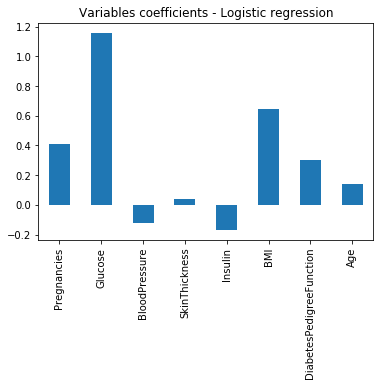

In [15]:
pd.Series(index=f_impute_zeros.drop(outcome,1).columns, data=model.steps[1][1].coef_[0]).plot(kind = 'bar')
plt.title('Variables coefficients - Logistic regression')
plt.show()

### Now, let's compare the "direction score" of random forest Vs logistic regression coefficients: 

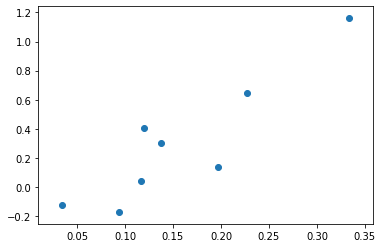

In [16]:
plt.scatter(directions.T.diff().iloc[1], model.steps[1][1].coef_[0])

In [17]:
pd.Series(index=directions.T.diff().iloc[1], data=model.steps[1][1].coef_[0]).reset_index().corr()

,>,0
>,1.000000,0.899041
0,0.899041,1.000000


In [18]:
ll =ll.drop(outcome)
ll['logreg'] = pd.Series(index=f_impute_zeros.drop(outcome,1).columns,data=model.steps[1][1].coef_[0])
ll.corr()

,l1,l2,logreg
l1,1.000000,0.923640,0.931709
l2,0.923640,1.000000,0.899041
logreg,0.931709,0.899041,1.000000


#### Fiarly correlated !

## Conclusions:
* We aimed to find a method that can produce equivalent to variables coefficients in logistic/linear regression
* For each variable, the suggested method maps the effect of each split on the outcome (higher/lower enrichment of the outcome)
* The method was applied on diabetes dataset and compared with logistic regression coefficients.
* Interestingly, the method was very correlated with the coefficients achieved by loistic regression. This implies for fairly linear correlations between the variables and the outcome. However, in cases of non-linear relations, it is expected that randomforests will produce very different results and will help to provide additional insights that could not be achieved by the linear models.